In [2]:
from imutils.perspective import four_point_transform
import imutils
import numpy as np
import argparse
import imutils
import cv2

In [3]:
from cv_course.lib import plot

In [4]:
%matplotlib notebook

In [5]:
# load the image, convert it to grayscale, blur it slightly, then find edges
image = cv2.imread('../images/test_01.png')

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [7]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

In [8]:
edged = cv2.Canny(blurred, 75, 200)

<IPython.core.display.Javascript object>


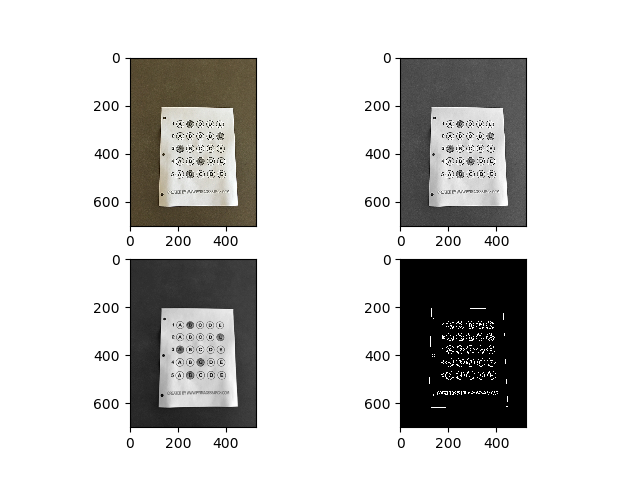

In [14]:
plot(image, gray, blurred, edged)

Fundamental hacer blurr, queda mucho mejor que gray sin más:

<IPython.core.display.Javascript object>


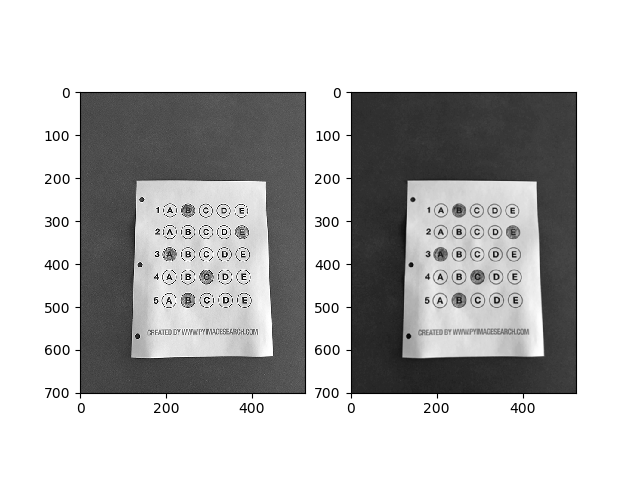

In [27]:
plot(gray, blurred)

Find main contour

In [9]:
# find contours in the edge map, then initialize the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
docCnt = None

In [10]:
# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

<IPython.core.display.Javascript object>


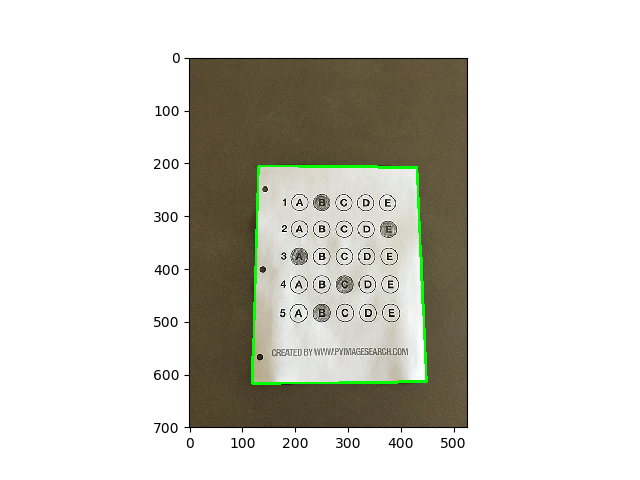

In [39]:
temp = image.copy()
cv2.drawContours(temp, [docCnt], -1, (0, 255, 0), 3)
plot(temp)

__transformar__

In [11]:
# apply a four point perspective transform to both the original image and grayscale image
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

<IPython.core.display.Javascript object>


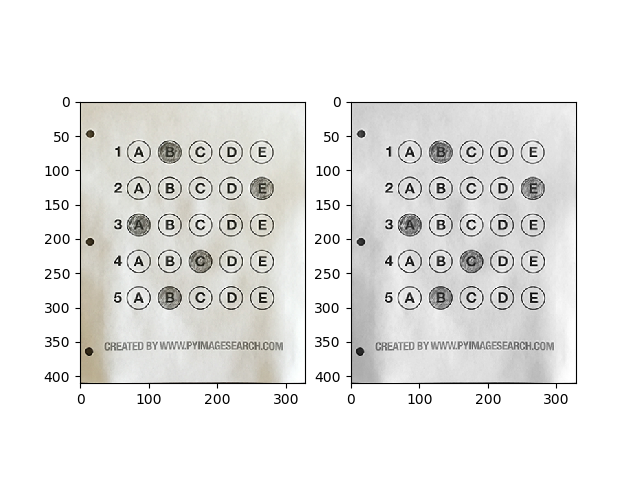

In [47]:
plot(paper, warped)

In [12]:
# apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]

<IPython.core.display.Javascript object>


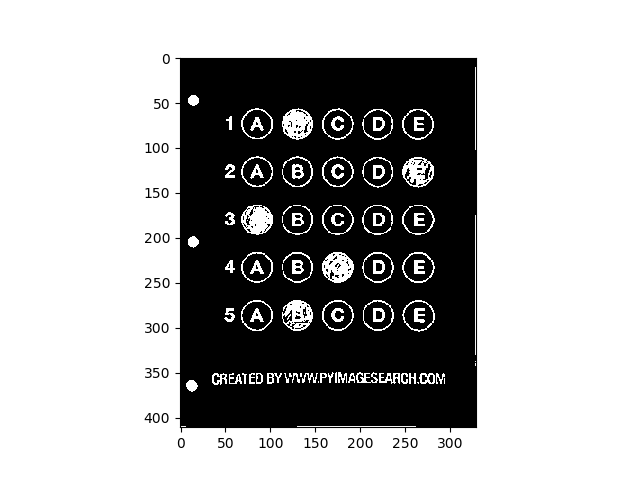

In [61]:
plot(thresh)

In [13]:
# find contours in the thresholded image, then initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
questionCnts = []

In [14]:
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

In [15]:
3

3

<IPython.core.display.Javascript object>


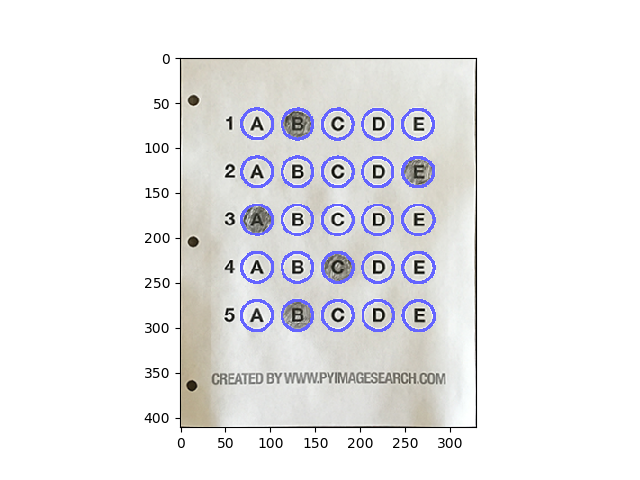

In [19]:
temp = paper.copy()
cv2.drawContours(paper, questionCnts, -1, (255, 0, 0), 2)
plot(temp)

In [20]:
import imutils.contours

In [21]:
# sort the question contours top-to-bottom, then initialize the total number of correct answers
questionCnts = imutils.contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0

In [22]:
# define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [23]:
len(questionCnts)

25

[INFO] score: 80.00%


<IPython.core.display.Javascript object>


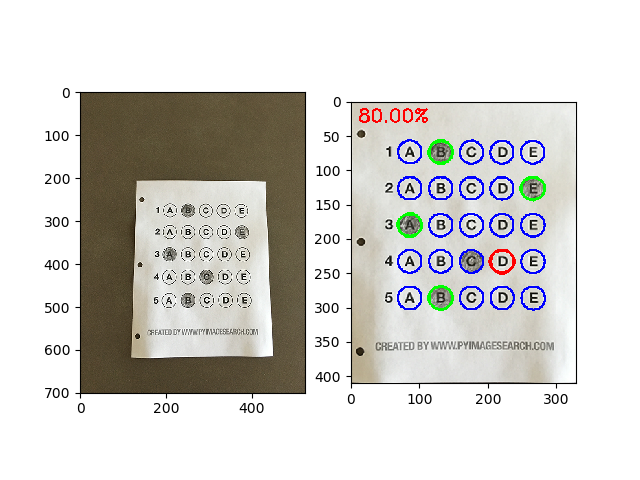

In [24]:
# each question has 5 possible answers, to loop over the question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from left to right, then initialize the index of the bubbled answer
    cnts = imutils.contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None

    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    # initialize the contour color and the index of the
    # *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]

    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1

    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

# grab the test taker
score = (correct / 5.0) * 100
print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plot(image, paper)